# Data aquisition, exploration and proprocessing

In [22]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from collections import Counter    

# Constants
COMMON_TOKENS = ["the", "to", "of", "and", "in", "for", "that", "is", "are", "on", "'s", "with", "as", "a",
                "it", "was", "be", "by", "said", "who", "at", "not", "this", "an", "or", "which"
                , "been", "but", "were", "also", "there", ".", ",", "/" , "\\", "\"", "\'", "(", ")", 
                "--", "-", "?", ";", ":"]


Data aquisition

In [15]:
# Loading text
dataset_path = "Dont_Patronize_Me_Trainingset"
split_dataset_path = f'{dataset_path}/data_splits'

df = pd.read_csv(
    f'{dataset_path}/dontpatronizeme_pcl.tsv', 
    names=["par_id", "art_id", "keyword", "country_code", "text", "label"],
    sep='\t', 
    skiprows=4
)

train_csv = pd.read_csv(f'{split_dataset_path}/train_semeval_parids-labels.csv', index_col=0)
dev_csv = pd.read_csv(f'{split_dataset_path}/dev_semeval_parids-labels.csv', index_col=0)
test_csv = pd.read_csv(f'{split_dataset_path}/task4_test.tsv', 
    names=["t_id", "art_id", "keyword", "country_code", "text"],
    sep='\t', 
    skiprows=4
)

print(df.describe(include="all"))

df.dropna(inplace=True)

              par_id      art_id  keyword country_code  \
count   10469.000000       10469    10469        10469   
unique           NaN       10093       10           20   
top              NaN  @@17361342  migrant           za   
freq             NaN           9     1089          549   
mean     5235.000000         NaN      NaN          NaN   
std      3022.284318         NaN      NaN          NaN   
min         1.000000         NaN      NaN          NaN   
25%      2618.000000         NaN      NaN          NaN   
50%      5235.000000         NaN      NaN          NaN   
75%      7852.000000         NaN      NaN          NaN   
max     10469.000000         NaN      NaN          NaN   

                                                     text         label  
count                                               10468  10469.000000  
unique                                              10468           NaN  
top     We 're living in times of absolute insanity , ...           NaN  
freq   

Data exploration - Basic Statistical Profiling

In [16]:
def create_binmap(x, bins):
    x = np.array(x)
    x_max, x_min = np.max(x), np.min(x)
    bin_width = math.ceil((x_max - x_min) / bins)
    bins = [ 0 for _ in range(bins) ]
    for x_i in x:
        bins[int((x_i-x_min)//bin_width)] += 1
    
    return bins

In [23]:
stats = df.describe(include="all")

print("> Counts")
print(stats.loc["count"])
print("-" * 50)

print("\n> Unique values")
print(stats.loc["unique"])
print("-" * 50)

print("\n> Sentence type analysis")
text_arr = df["text"].to_numpy()
type_func = np.vectorize(lambda x: type(x) == str)
text_types = type_func(text_arr)
(tys, indices, counts) = np.unique(text_types, return_index=True, return_counts=True)
if (len(tys) > 1):
    print("Non-string sentence found")
    bad_indx = int(indices[0])
    print(f'Badly typed sentence at row with id {df["par_id"][bad_indx]}')
else:
    print("All texts are well typed")
print("-" * 50)

print("\n> Par ID uniqueness check")
parid_arr = df["par_id"].to_numpy()
_, cs = np.unique(parid_arr, return_counts=True)
print(f'{sum(map(lambda x: x > 1, cs))} non-unique par_ids found')
print("-" * 50)

print("\n> Art ID uniqueness check")
artid_arr = df["art_id"].to_numpy()
vs, cs = np.unique(artid_arr, return_counts=True)
print_count, print_limit = 0, 10
bad_indices = list(map(lambda x: x > 1, cs))
print(f'{sum(bad_indices)} non-unique art_ids found')
for i, bi in enumerate(bad_indices):
    if bi: print(f'Non-unique art_id found: {vs[i]}'); print_count += 1
    if print_count > print_limit: break
print("-" * 50)

print("\n> Keyword uniqueness check")
keyword_arr = df["keyword"].to_numpy()
print(np.unique(keyword_arr))
print("-" * 50)

print("\n> Country code uniqueness check")
country_code_arr = df["country_code"].to_numpy()
codes, code_counts = np.unique(country_code_arr, return_counts=True)
print(list(zip(codes, [int(c) for c in code_counts])))
print("-" * 50)

print("\n> Label analysis")
label_arr = df["label"].to_numpy()
labels, label_counts = np.unique(label_arr, return_counts=True)
print(list(zip([int(l) for l in labels], [int(c) for c in label_counts])))
print(f'Number of negative labels: {int(label_counts[0])}')
print(f'Number of positive labels: {int(sum(label_counts[1:]))}')
print("-" * 50)

print("\n> Token analysis")
word_occurences = {}
for sentence in df["text"].to_numpy():
    for token in sentence.split():
        token = token.lower()
        if token not in word_occurences: 
            word_occurences[token] = 1
        else:
            word_occurences[token] += 1
word_occurences = dict(sorted(word_occurences.items(), key=lambda item: -item[1]))
uncommon_word_occurences = word_occurences.copy()
for cw in COMMON_TOKENS:
    if cw in uncommon_word_occurences: del uncommon_word_occurences[cw]
print(f'{len(word_occurences)} unique tokens excluding ')
print(word_occurences)
print(uncommon_word_occurences)
print("-" * 50)

print("\n> Sentence length analysis")
len_func = np.vectorize(lambda x: len(x.split()))
text_lens = len_func(df["text"].to_numpy())
len_max, len_min = np.max(text_lens), np.min(text_lens)
print(f'max num of tokens in a sentence: {len_max}')
print(f'min num of tokens in a sentence: {len_min}')
print(f'mean num of tokens in a sentence: {np.mean(text_lens)}')
print(f'median num of tokens in a sentence: {np.median(text_lens)}')
print(f'standard deviation num of tokens in a sentence: {np.std(text_lens)}')
print(f'{10} bin equiwidth binmap of sentence length: {create_binmap(text_lens, 10)}')
print(f'{25} bin equiwidth binmap of sentence length: {create_binmap(text_lens, 25)}')
print("-" * 50)

> Counts
par_id          10457.0
art_id            10457
keyword           10457
country_code      10457
text              10457
label           10457.0
Name: count, dtype: object
--------------------------------------------------

> Unique values
par_id            NaN
art_id          10081
keyword            10
country_code       20
text            10457
label             NaN
Name: unique, dtype: object
--------------------------------------------------

> Sentence type analysis
All texts are well typed
--------------------------------------------------

> Par ID uniqueness check
0 non-unique par_ids found
--------------------------------------------------

> Art ID uniqueness check
310 non-unique art_ids found
Non-unique art_id found: @@10009675
Non-unique art_id found: @@10033933
Non-unique art_id found: @@10033982
Non-unique art_id found: @@10035251
Non-unique art_id found: @@10040395
Non-unique art_id found: @@10041607
Non-unique art_id found: @@10058915
Non-unique art_id found: @

Data exploration - Graphs

200 bin equiwidth binmap for text lengths: [(1, 27), (6, 195), (11, 279), (16, 440), (21, 750), (26, 977), (31, 1117), (36, 1147), (41, 993), (46, 797), (51, 648), (56, 544), (61, 444), (66, 364), (71, 313), (76, 258), (81, 208), (86, 170), (91, 135), (96, 116), (101, 91), (106, 78), (111, 72), (116, 60), (121, 41), (126, 38), (131, 30), (136, 21), (141, 32), (146, 16), (151, 10), (156, 15), (161, 10), (166, 9), (171, 2), (176, 7), (181, 0), (186, 3), (191, 0), (196, 0), (201, 1), (206, 0), (211, 1), (216, 1), (221, 0), (226, 1), (231, 0), (236, 0), (241, 0), (246, 0), (251, 1), (256, 0), (261, 0), (266, 1), (271, 1), (276, 0), (281, 0), (286, 0), (291, 0), (296, 0), (301, 0), (306, 0), (311, 0), (316, 0), (321, 0), (326, 0), (331, 0), (336, 0), (341, 0), (346, 0), (351, 0), (356, 0), (361, 0), (366, 0), (371, 0), (376, 0), (381, 0), (386, 1), (391, 0), (396, 0), (401, 0), (406, 0), (411, 0), (416, 1), (421, 0), (426, 0), (431, 0), (436, 0), (441, 0), (446, 0), (451, 0), (456, 0), (461

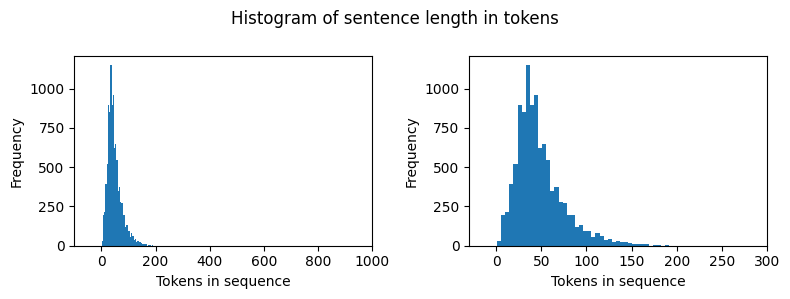

In [18]:
# Data visualisation (Sequence length binmaps)
n = 200
bin_width = math.ceil((len_max - len_min) / n)
binmap = list(zip([ int(len_min) + (bin_width * i) for i in range(n) ], create_binmap(text_lens, n)))
print(f'{n} bin equiwidth binmap for text lengths: {binmap}')

fig, axs = plt.subplots(1, 2)
axs[0].hist(text_lens, bins=n)
axs[0].set_xlim(-100,1000)
axs[1].hist(text_lens, bins=n)
axs[1].set_xlim(-30,300)

for i in [0, 1]:
    axs[i].set_xlabel("Tokens in sequence")
    axs[i].set_ylabel("Frequency")

fig.set_size_inches(8, 3)
fig.suptitle('Histogram of sentence length in tokens')
plt.tight_layout()
plt.savefig("./sentence_len_fig.png")
plt.show()

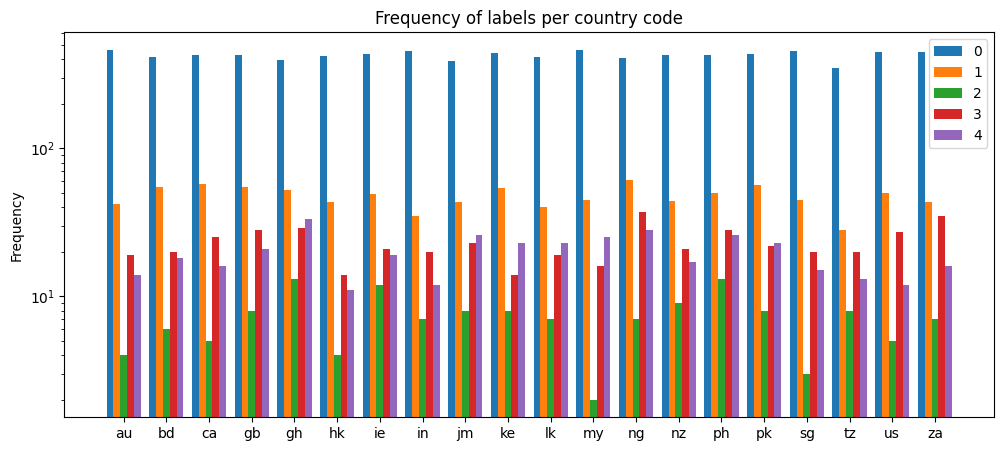

In [19]:
# Data visualisation (Country code and labels)
country_codes = list(df["country_code"].to_numpy())
codes, labels = list(codes), list(map(int, df["label"].to_numpy()))
zipped = list(zip(country_codes, labels))
agg = {}

# Initalise agg object
for i in range(5):
    agg[i] = [0 for _ in range(len(codes))]

for (cc, l) in zipped:
    agg[l][codes.index(cc)] += 1

fig, ax = plt.subplots()
fig.set_size_inches((12, 5))

bar_width, multiplier = 0.16, 0
label_locations = np.arange(len(codes))
for cc, ls in agg.items():
    offset = bar_width * multiplier
    rects = ax.bar(label_locations + offset - bar_width, ls, bar_width, label=cc)
    multiplier += 1

ax.set_ylabel('Frequency')
ax.set_title('Frequency of labels per country code')
ax.set_xticks(label_locations + bar_width, codes)
ax.legend(loc='upper right')
ax.set_yscale("log")

plt.savefig("./country_code_label_frequency.png")
plt.show()

Data preprocessing - Identifying noise and artifacts

In [ ]:
# Clean HTML tokens
# &amp;         has 73 occurences in dataset
# More&gt;&gt;  has 15 occurences in dataset
# &gt;          has 33 occurences in dataset
# <h>           506 occurences in dataset
texts = df["text"].to_numpy()
rules = [("&amp;", "&"), ("More&gt;&gt;", ""), ("&gt;", ""), ("<h>", ""), (". .", "."), ("  ", " "), ("  ", " ")]
counter = 0
for (substring, replacement) in rules:
    df.loc[:, "text"] = df.loc[:, "text"].str.replace(substring, replacement) 

# Remove records with abnormally long sentence length
threshold = 200
texts = df["text"].to_numpy()
good_indices = list(map(lambda a: len(a.split()) < threshold, texts))
df = df[good_indices]
print(f'{len(texts) - sum(good_indices)} samples removed which had text length greater than threshold of {threshold}')


11 samples removed which had text length greater than threshold of 200
